In [67]:
import os
from fastai.data.external import untar_data, URLs


import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

import numpy as np

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


Скачиваем датасет CIFAR10

In [68]:


dataset = torchvision.datasets.CIFAR10(root='./data', download=True)

Files already downloaded and verified


Подсчёт коэффициентов для нормализации изображений

In [69]:

stats = ((0.5, 0.5, 0.5), (0.3, 0.3, 0.3))
transform = transforms.Compose(
    [transforms.ToTensor(), 
    transforms.Normalize(*stats,inplace=True)])

In [70]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

batch_size = 100
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)

Выводим 10 разных изображений и их класс


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.614379..1.627451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.614379..1.5751634].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6666666..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6013072..1.5882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6666666..1.6666666].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3006536..1.4052287].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.614379..

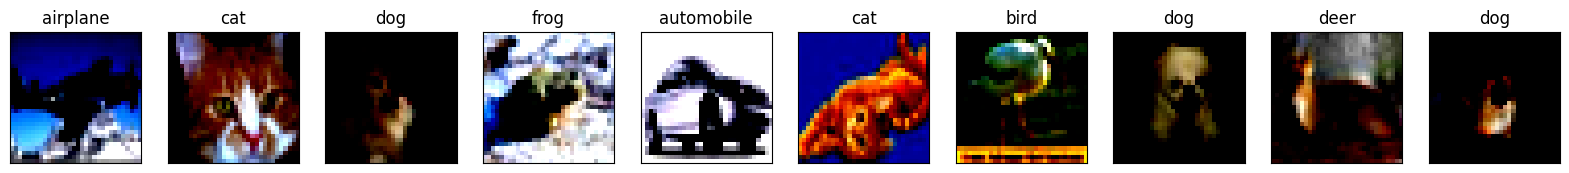

In [71]:
def visualize(dataset):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    images = images.numpy()
    fig = plt.figure(figsize=(20, 20))
    for idx in np.arange(10):
        ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[idx], (1,2,0)))
        ax.set_title(train_dataset.classes[labels[idx]])
visualize(trainloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.496732..1.6666666].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6666666..1.5620915].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.627451..1.627451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2352941..1.3921568].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5882353..1.2091503].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6666666..1.0915033].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6666666..

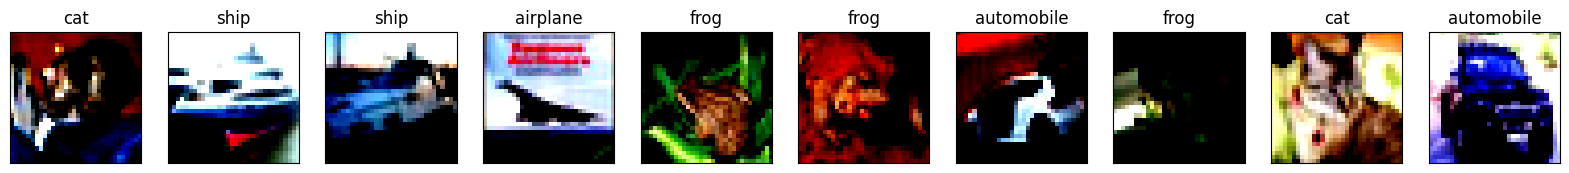

In [72]:
visualize(testloader)

Проверка доступности устройства Cuda, а также пересылка dataloaders на это устройство, в противном случае переносим на Cpu

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


device = get_default_device()

trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)

Определяем функцию для подсчёта точности и потерь


In [74]:

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Создадим для удобства расширение для нашей модели

In [75]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)  
        return loss,acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['train_accuracy'], result['val_loss'], result['val_acc']))

Модель AlexNet с изменениями под Cifar-10

In [76]:
class AlexNet(ImageClassificationBase):
    def __init__(self, num_classes: int = 10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 4096),  # 256*4*4 вместо 256*6*6
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
net = AlexNet()
net.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace

In [77]:
from torchinfo import summary

summary(net, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [100, 10]                 --
├─Sequential: 1-1                        [100, 256, 4, 4]          --
│    └─Conv2d: 2-1                       [100, 64, 32, 32]         1,792
│    └─ReLU: 2-2                         [100, 64, 32, 32]         --
│    └─LocalResponseNorm: 2-3            [100, 64, 32, 32]         --
│    └─MaxPool2d: 2-4                    [100, 64, 16, 16]         --
│    └─Conv2d: 2-5                       [100, 192, 16, 16]        110,784
│    └─ReLU: 2-6                         [100, 192, 16, 16]        --
│    └─LocalResponseNorm: 2-7            [100, 192, 16, 16]        --
│    └─MaxPool2d: 2-8                    [100, 192, 8, 8]          --
│    └─Conv2d: 2-9                       [100, 384, 8, 8]          663,936
│    └─ReLU: 2-10                        [100, 384, 8, 8]          --
│    └─Conv2d: 2-11                      [100, 256, 8, 8]          884,9

Создадим папку, чтобы сохранить нашу модель

In [78]:
MODEL_PATH = "models/"
MODEL_EXP_PATH = MODEL_PATH + "alexnet/"
try:
    os.mkdir(MODEL_PATH)
except:
    print("Folder already exists")

try:
    os.mkdir(MODEL_EXP_PATH)
except:
    print("Folder already exists")

Folder already exists
Folder already exists


Функции тренировки и тестирования


In [79]:
import torch.optim as optim
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,weight_decay=0, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func
    best_accuracy=0.0
    best_train_loss = 100
    all_predictions = 0
    correct_predictions = 0
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracy= []
        running_loss = 0.0
        for (batch_idx, batch) in enumerate(train_loader):
            

            loss, accuracy = model.training_step(batch)

            train_losses.append(loss)
            train_accuracy.append(accuracy)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracy).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        if result['train_accuracy']>best_accuracy:
            best_accuracy=result['train_accuracy']
            torch.save(model.state_dict(), MODEL_EXP_PATH + "/baseline_model_accuracy")

        if result['train_loss']<best_train_loss:
            best_train_loss = result['train_loss']
            torch.save(model.state_dict(), MODEL_EXP_PATH + "/baseline_model_loss")
    return history

Проверим точность нашей модели до тренировки

In [80]:

evaluate(net, testloader)

{'val_loss': 2.3026461601257324, 'val_acc': 0.10000000149011612}

Введём гиперпараметры: кол-во эпох, скорсоть обучения и есть ли сдвин(bias) и какую функцию оптимизации используем



In [81]:
epochs = 50
max_lr = 0.01
momentum=0.9
weight_decay = 5e-4
opt_func = optim.SGD(net.parameters(), max_lr, momentum=momentum, weight_decay=weight_decay)

In [82]:
%%time
history = fit_one_cycle(epochs, max_lr, net, trainloader, testloader,
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [1], train_loss: 2.3020, train_acc: 0.1072, val_loss: 2.2958, val_acc: 0.1603
Epoch [2], train_loss: 1.9537, train_acc: 0.2694, val_loss: 1.6623, val_acc: 0.3609
Epoch [3], train_loss: 1.5327, train_acc: 0.4243, val_loss: 1.3756, val_acc: 0.4910
Epoch [4], train_loss: 1.3198, train_acc: 0.5150, val_loss: 1.1570, val_acc: 0.5740
Epoch [5], train_loss: 1.1509, train_acc: 0.5782, val_loss: 1.0851, val_acc: 0.6064
Epoch [6], train_loss: 1.0184, train_acc: 0.6314, val_loss: 0.9646, val_acc: 0.6546
Epoch [7], train_loss: 0.9036, train_acc: 0.6776, val_loss: 0.9056, val_acc: 0.6866
Epoch [8], train_loss: 0.8155, train_acc: 0.7083, val_loss: 0.7843, val_acc: 0.7237
Epoch [9], train_loss: 0.7293, train_acc: 0.7428, val_loss: 0.7320, val_acc: 0.7439
Epoch [10], train_loss: 0.6674, train_acc: 0.7634, val_loss: 0.6781, val_acc: 0.7621
Epoch [11], train_loss: 0.6104, train_acc: 0.7854, val_loss: 0.6548, val_acc: 0.7725
Epoch [12], train_loss: 0.5608, train_acc: 0.8020, val_loss: 0.6347, val_a

Введём функции, которые построят графики изменения точности, потерь в течение эпох

In [83]:
def plot_accuracies(history):
    train_accuracies= [x['train_accuracy'] for x in history]
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-bx')
    plt.plot(train_accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Validation','Training'])
    plt.title('Accuracy vs. No. of epochs')

In [84]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

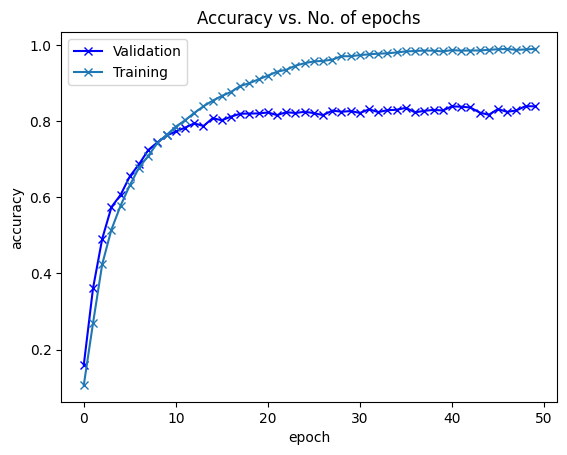

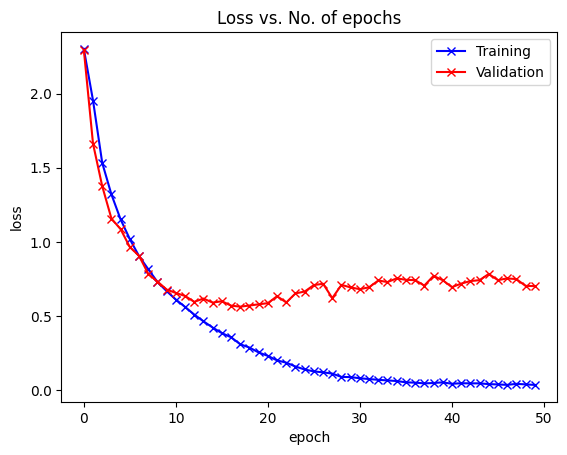

In [85]:

plot_accuracies(history)
plt.show()
plot_losses(history)
plt.show()

Сохраним нашу нейронную модель


In [86]:
torch.save(net.state_dict(), MODEL_PATH + '/model')

Загрузим нашу модель для проверки


In [87]:

net2 = to_device(AlexNet(), device)

In [88]:
net2.load_state_dict(torch.load(MODEL_PATH + 'model'))

C:\Users\Otche\AppData\Local\Temp\ipykernel_6076\544327019.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net2.load_state_dict(torch.load(MODEL_PATH + 'model'))


<All keys matched successfully>

In [89]:
evaluate(net2, testloader)

{'val_loss': 0.7012450098991394, 'val_acc': 0.8383999466896057}

In [90]:
modelbest=to_device(AlexNet(), device)
modelbest.load_state_dict(torch.load(MODEL_EXP_PATH + 'baseline_model_loss'))

C:\Users\Otche\AppData\Local\Temp\ipykernel_6076\529466087.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelbest.load_state_dict(torch.load(MODEL_EXP_PATH + 'baselin

<All keys matched successfully>

In [91]:
evaluate(modelbest, testloader)

{'val_loss': 0.7012450098991394, 'val_acc': 0.8383999466896057}